**Initialization**
- I use these three lines of code on top of my each notebooks because it will help to prevent any problems while reloading the same project. And the third line of code helps to make visualization within the notebook.

In [3]:
#@ INITIALIZATION: 
%reload_ext autoreload
%autoreload 2
%matplotlib inline

**Downloading Libraries and Dependencies**
- I have downloaded all the libraries and dependencies required for the project in one particular cell.

In [29]:
#@ IMPORTING MODULES: UNCOMMENT BELOW:
# !pip install transformers
# !pip install scikit-multilearn
# !pip install datasets
import time
import math
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
from collections import defaultdict
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.feature_extraction.text import CountVectorizer
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.model_selection import iterative_train_test_split

#@ IGNORING WARNINGS: 
import warnings
warnings.filterwarnings("ignore")

**Getting Data**

In [5]:
#@ FUNCTION FOR FETCHING ISSUES DATA: 
def fetch_issues(owner="huggingface", repo="transformers", num_issues=10_000,
                 rate_limit=5_000):                                                 # Defining function.
    batch = []                                                                      # Initialization.
    all_issues = []                                                                 # Initialization.
    per_page = 100                                                                  # Initialization.
    num_pages = math.ceil(num_issues / per_page)                                    # Initialization.
    base_url = "https://api.github.com/repos"                                       # Initialization.
    for page in tqdm(range(num_pages)):
        query = f"issues?page={page}&per_page={per_page}&state=all"
        issues = requests.get(f"{base_url}/{owner}/{repo}/{query}")                 # Getting issues.
        batch.extend(issues.json())
        if len(batch) > rate_limit and len(all_issues) < num_issues:
            all_issues.extend(batch)
            batch = []
            print(f"Reached GitHub rate limit. Sleeping for one hour")
            time.sleep(60 * 60 + 1)
    all_issues.extend(batch)                                                        # Adding issues.
    df = pd.DataFrame.from_records(all_issues)                                      # Creating the dataframe.
    df.to_json(f"github-issues-{repo}.jsonl", orient="records", lines=True)         # Convertin to json.

#@ GETTING THE DATA: UNCOMMENT BELOW:
# fetch_issues()

In [6]:
#@ GETTING THE DATA: UNCOMMENT BELOW:
# !wget https://raw.githubusercontent.com/nlp-with-transformers/notebooks/main/data/github-issues-transformers.jsonl

**Preparing Data**

In [7]:
#@ PREPARING THE DATA:
dataset_url = "https://git.io/nlp-with-transformers"            # Initialization.
df_issues = pd.read_json(dataset_url, lines=True)               # Creating dataframe. 
print(f"DataFrame shape: {df_issues.shape}")                    # Inspecting shape.

DataFrame shape: (9930, 26)


In [8]:
#@ PREPARING THE DATA:
cols = ["url", "id", "title", "user", "labels", "state", "created_at", "body"]      # Initializing column names.
df_issues.loc[2, cols].to_frame()                                                   # Inspection.

,2
url,https://api.github.com/repos/huggingface/trans...
id,849529761
title,[DeepSpeed] ZeRO stage 3 integration: getting ...
user,"{'login': 'stas00', 'id': 10676103, 'node_id':..."
labels,"[{'id': 2659267025, 'node_id': 'MDU6TGFiZWwyNj..."
state,open
created_at,2021-04-02 23:40:42
body,"**[This is not yet alive, preparing for the re..."


In [9]:
#@ INSPECTING THE DATAFRAME: LABELS:
df_issues["labels"] = df_issues["labels"].apply(lambda x: [meta["name"] for meta in x])     # Initializing labels.
df_issues[["labels"]].head()

,labels
0,[]
1,[]
2,[DeepSpeed]
3,[]
4,[]


In [10]:
#@ INSPECTING THE LABELS:
df_issues["labels"].apply(lambda x: len(x)).value_counts().to_frame().T

,0,1,2,3,4,5
labels,6440,3057,305,100,25,3


In [11]:
#@ INSPECTING THE LABELS: FREQUENT:
df_counts = df_issues["labels"].explode().value_counts()        # Exploding the labels column.
print(f"Number of labels: {len(df_counts)}")                    # Inspection.
df_counts.to_frame().head(7).T                                  # Inspecting labels.

Number of labels: 65


,wontfix,model card,Core: Tokenization,New model,Core: Modeling,Help wanted,Good First Issue
labels,2284,649,106,98,64,52,50


In [12]:
#@ PREPARING THE LABELS COLUMN:
label_map = {"Core: Tokenization": "tokenization", 
             "New model": "new model",
             "Core: Modeling": "model training",
             "Usage": "usage", 
             "Core: Pipeline": "pipeline",
             "TensorFlow": "tensorflow or tf",
             "PyTorch": "pytorch", 
             "Examples": "examples", 
             "Documentation": "documentation"}                          # Standardization of labels.
def filter_labels(x):                                                   # Defining function. 
    return [label_map[label] for label in x if label in label_map]      # Filtering labels.
df_issues["labels"] = df_issues["labels"].apply(filter_labels)          # Implementation of filtering.
all_labels = list(label_map.values())                                   # Initializing labels.
all_labels                                                              # Inspection.

['tokenization',
 'new model',
 'model training',
 'usage',
 'pipeline',
 'tensorflow or tf',
 'pytorch',
 'examples',
 'documentation']

In [13]:
#@ INSPECTING DISTRIBUTION OF LABELS:
df_counts = df_issues["labels"].explode().value_counts()        # Exploding the labels column.
df_counts.to_frame().T                                          # Inspecting labels.

,tokenization,new model,model training,usage,pipeline,tensorflow or tf,pytorch,documentation,examples
labels,106,98,64,46,42,41,37,28,24


In [14]:
#@ SPLITTING LABELED AND UNLABELED ISSUES:
df_issues["split"] = "unlabeled"                                # Initialization.
mask = df_issues["labels"].apply(lambda x: len(x)) > 0          # Initializing mask.
df_issues.loc[mask, "split"] = "labeled"                        # Initialization.
df_issues["split"].value_counts().to_frame().T                  # Inspection.

,unlabeled,labeled
split,9489,441


In [15]:
#@ INSPECTING AN EXAMPLE:
for column in ["title", "body", "labels"]:
    print(f"{column}: {df_issues[column].iloc[26][:500]}\n")

title: Add new CANINE model

body: # 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokenization step. While recent tokenization approaches based on data-derived subword lexicons are less brittle than manually en

labels: ['new model']



In [16]:
#@ PREPARING TEXT COLUMNS:
df_issues["text"] = (df_issues.apply(lambda x: x["title"] + "\n\n" + x["body"], axis=1))    # Creating text column.
df_issues[["text"]].head()

,text
0,Potential incorrect application of layer norm ...
1,Multi-GPU seq2seq example evaluation significa...
2,[DeepSpeed] ZeRO stage 3 integration: getting ...
3,Can't load model to estimater\n\nI was trying ...
4,[LXMERT] Unclear what img_tensorize does with ...


In [17]:
#@ REMOVING DUPLICATES:
len_before = len(df_issues)                                                     # Inspection.
df_issues = df_issues.drop_duplicates(subset="text")                            # Dropping duplicates.
print(f"Removed {(len_before-len(df_issues))/len_before:.2%} duplicates.")      # Inspection.

Removed 1.88% duplicates.


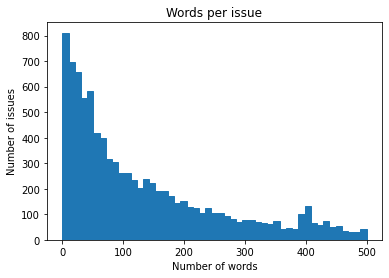

In [18]:
#@ VISUALIZING THE NUMBER OF WORDS:
(df_issues["text"].str.split().apply(len).hist(
    bins=np.linspace(0, 500, 50), grid=False, edgecolor="C0"))                  # Plotting histograms.
plt.title("Words per issue")
plt.xlabel("Number of words")
plt.ylabel("Number of issues")
plt.show()                                                                      # Inspection.

**Creating Training Sets**

In [19]:
#@ INITIALIZING MULTILABEL BINARIZER: EXAMPLE:
mlb = MultiLabelBinarizer()                                     # Initializing multi label binarizer.
mlb.fit([all_labels])                                           # Fitting labels.
mlb.transform([["tokenization", "new model"],["pytorch"]])      # Inspection.

array([[0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0]])

In [20]:
#@ FUNCTION FOR SPLITTING DATASET:
def balanced_split(df, test_size=0.5):                              # Defining function.
    ind = np.expand_dims(np.arange(len(df)), axis=1)                # Expanding dimensions. 
    labels = mlb.transform(df["labels"])                            # Transforming labels.
    ind_train, _, ind_test, _ = iterative_train_test_split(
        ind, labels, test_size)                                     # Initializing training and test splits.
    return df.iloc[ind_train[:, 0]], df.iloc[ind_test[:, 0]]

In [21]:
#@ SUPERVISED AND UNSUPERVISED DATAFRAME:
df_clean = df_issues[["text", "labels", "split"]].reset_index(drop=True).copy()     # Initializing dataframe.
df_unsup = df_clean.loc[df_clean["split"] == "unlabeled", ["text", "labels"]]       # Initializing unsupervised dataframe.
df_sup = df_clean.loc[df_clean["split"] == "labeled", ["text", "labels"]]           # Initializing supervised dataframe.
df_sup.head()                                                                       # Inspecting dataframe. 

,text,labels
26,Add new CANINE model\n\n# 🌟 New model addition...,[new model]
107,Please implement DUMA: Reading Comprehension w...,[new model]
207,Add GPT-Neo\n\n# 🌟 New model addition\r\n\r\nP...,[new model]
264,Can DeepSpeed ZeRO-3 be applied for training? ...,[new model]
439,Implementing efficient self attention in T5\n\...,[new model]


In [22]:
#@ INITIALIZING TRAINING AND TEST SPLITS:
np.random.seed(2022)                                                        # Initialization.
df_train, df_tmp = balanced_split(df_sup, test_size=0.5)                    # Creating training splits.
df_valid, df_test = balanced_split(df_tmp, test_size=0.5)                   # Creating test splits.

In [23]:
#@ INITIALIZING DATASETDICT:
ds = DatasetDict({
    "train": Dataset.from_pandas(df_train.reset_index(drop=True)),          # Training dataset.
    "valid": Dataset.from_pandas(df_valid.reset_index(drop=True)),          # Validation dataset.
    "test": Dataset.from_pandas(df_test.reset_index(drop=True)),            # Test dataset.
    "unsup": Dataset.from_pandas(df_unsup.reset_index(drop=True))
})                                                                          # Initializing datasetdict. 
ds                                                                          # Inspection.

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 216
    })
    valid: Dataset({
        features: ['text', 'labels'],
        num_rows: 114
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 110
    })
    unsup: Dataset({
        features: ['text', 'labels'],
        num_rows: 9303
    })
})

**Creating Training Slices**

In [24]:
#@ CREATING TRAINING SLICES:
np.random.seed(2022)                                                        # Initialization.
all_indices = np.expand_dims(list(range(len(ds["train"]))), axis=1)         # Expanding dimensions.
indices_pool = all_indices                                                  # Initialization.
labels = mlb.transform(ds["train"]["labels"])                               # Initializing multilabels.
train_samples = [8, 16, 32, 64, 128]                                        # Initializing training sample size.
train_slices, last_k = [], 0                                                # Initialization.
for i,k in enumerate(train_samples):
    indices_pool, labels, new_slice, _ = iterative_train_test_split(
        indices_pool, labels, (k-last_k)/len(labels))                       # Splitting samples. 
    last_k = k
    if i==0:
        train_slices.append(new_slice)                                      # Adding training slices.
    else:
        train_slices.append(np.concatenate((train_slices[-1], new_slice)))  # Adding training slices.
train_slices.append(all_indices), train_samples.append(len(ds["train"]))    # Appending.
train_slices = [np.squeeze(train_slice) for train_slice in train_slices]    # Initializing training slices.

#@ INSPECTING TRAINING SPLITS:
print("Target split sizes:")
print(train_samples)
print("Actual split sizes:")
print([len(x) for x in train_slices])

Target split sizes:
[8, 16, 32, 64, 128, 216]
Actual split sizes:
[10, 20, 39, 71, 139, 216]


**Implementing Naive Bayes Classifier**

In [25]:
#@ FUNCTION FOR PREPARING LABELS:
def prepare_labels(batch):                                      # Defining function.
    batch["label_ids"] = mlb.transform(batch["labels"])         # Initializing label ids.
    return batch

#@ IMPLEMENTATION OF FUNCTION:
ds = ds.map(prepare_labels, batched=True)                       # Preparing labels.
ds                                                              # Inspection.

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'label_ids'],
        num_rows: 216
    })
    valid: Dataset({
        features: ['text', 'labels', 'label_ids'],
        num_rows: 114
    })
    test: Dataset({
        features: ['text', 'labels', 'label_ids'],
        num_rows: 110
    })
    unsup: Dataset({
        features: ['text', 'labels', 'label_ids'],
        num_rows: 9303
    })
})

In [30]:
#@ INITIALIZING NAIVEBAYES CLASSIFIER:
macro_scores, micro_scores = defaultdict(list), defaultdict(list)                   # Initialization.
for train_slice in train_slices:
    ds_train_sample = ds["train"].select(train_slice)                               # Getting training slice.
    y_train = np.array(ds_train_sample["label_ids"])                                # Getting training labels.
    y_test = np.array(ds["test"]["label_ids"])                                      # Getting test labels.
    count_vect = CountVectorizer()                                                  # Initializing count vectorizer.
    X_train_counts = count_vect.fit_transform(ds_train_sample["text"])              # Encoding text as tokens.
    X_test_counts = count_vect.transform(ds["test"]["text"])                        # Encoding text as tokens.
    classifier = BinaryRelevance(classifier=MultinomialNB())                        # Initializing multilabel classifier.
    classifier.fit(X_train_counts, y_train)                                         # Training classifier.
    y_pred_test = classifier.predict(X_test_counts)                                 # Generating predictions.
    clf_report = classification_report(y_test, y_pred_test, 
                                       target_names=mlb.classes_, zero_division=0,
                                       output_dict=True)                            # Initializing classification report. 
    macro_scores["Naive Bayes"].append(clf_report["macro avg"]["f1-score"])         # Adding macro average scores.
    micro_scores["Naive Bayes"].append(clf_report["micro avg"]["f1-score"])         # Adding micro average scores.

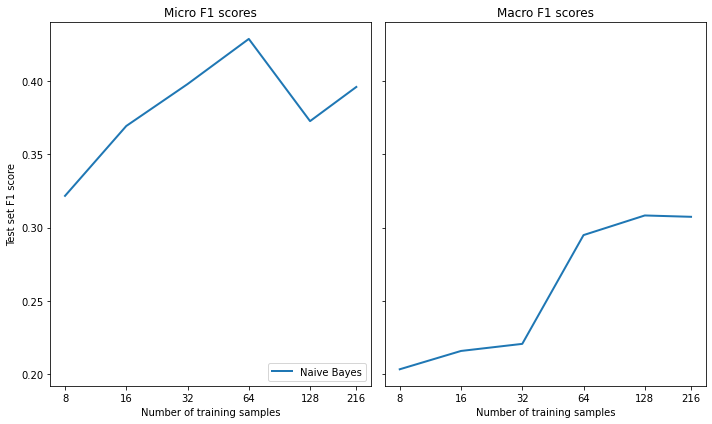

In [32]:
#@ FUNCTION FOR PLOTTING METRICS:
def plot_metrics(micro_scores, macro_scores, sample_sizes, current_model):              # Defining function. 
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,6), sharey=True)
    for run in micro_scores.keys():
        if run == current_model:
            ax0.plot(sample_sizes, micro_scores[run], label=run, linewidth=2)
            ax1.plot(sample_sizes, macro_scores[run], label=run, linewidth=2)
        else:
            ax0.plot(sample_sizes, micro_scores[run], label=run, linestyle="dashed")
            ax1.plot(sample_sizes, macro_scores[run], label=run, linestyle="dashed")
    ax0.set_title("Micro F1 scores")
    ax1.set_title("Macro F1 scores")
    ax0.set_ylabel("Test set F1 score")
    ax0.legend(loc="lower right")
    for ax in [ax0, ax1]:
        ax.set_xlabel("Number of training samples")
        ax.set_xscale("log")
        ax.set_xticks(sample_sizes)
        ax.set_xticklabels(sample_sizes)
        ax.minorticks_off()
    plt.tight_layout()
    plt.show()

#@ IMPLEMENTATION OF FUNCTION:
plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes")